# Deep Convolutional Generative Adversarial Network (DCGAN)

The following notebook was created in support of a GAN training session I did for my coworkers and  demonstrates how to build and train a relatively simple DCGAN from scratch using TensorFlow 2.0+ (PyTorch version coming soon). <br>
Enjoy!

### Quick recap...

We saw earlier that GANs can be used for generating synthetic data, including images, videos, and even text.  In this notebook, we'll look at the "hello world" of GANs... generating handwritten digits (MNIST).

Recall that a GAN is comprised of a Generator and at least one Discriminator. <br>
The Generator's roll is to create brand new images that resemble as closely as possible, features from the training data (MNIST in our case).  The Discriminator on the other hand, is trying to determine if the image it's seeing is real or fake (a mixture of real MNIST digits and our generated digits).<br><br>
During training, the Discriminator the gives it's feedback to the Generator, which in turn updates it's parameters (weights) so that the next batch of images it produces will hopefully trick the Discriminator into thinking they're real. <br>
This training cycle continues as the Generator becomes better at creating fake images that look real, while the Discriminator gets better at telling them apart.  Training is done when the process reaches equilibrium (aka - Nash Equilibrium) when the Discriminator can no longer distinguish the fake images from the real images (50/50 guess that that point).

### Let's get started!

In [1]:
# Additional packages needed to generate GIFs
#!pip3 install -q imageio
#!pip install -q git+https://github.com/tensorflow/docs

# To plot model architecture (will add this functionality later)
#!pip3 install pydot

# The usual imports...
import os
import glob
import time

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import imageio
import PIL
from IPython import display

### Load and preprocess the MNIST dataset

We'll train the generator and discriminator using the MNIST dataset as the "truth" (real) data for the discriminator to learn from.  The Generator will start learning how to generate handwritten digits that resemble the MNIST digits.

In [2]:
# we only care about the training images, so we disregard the test images
(train_imgs, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() 

# We'll normalize the pixel values to be between [-1, 1]
train_imgs = train_imgs.reshape(train_imgs.shape[0], 28, 28, 1).astype('float32')
train_imgs = (train_imgs - 127.5) / 127.5

# Set batch size and shuffle the dataset
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_imgs).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Create the Generator and Discriminator models

Starting with our <b>Generator</b> network, we'll use multiple blocks consisting of a Transpose Convolution, Batch Normalization, and Leaky Relu layer to convert our noise vector into an image and gradually upscale it to a 28x28 image (same as MNIST).<br>
We'll start with a fully-connected layer that receives our input noise vector and convert it to a 7x7 image.  Then we'll double that to a 14x14 image, and finally, we'll double it again to a 28x28 image.

In [3]:
def generator_model():
    model = tf.keras.Sequential()
    # First block: receives our input vector and reshapes it
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    
    # Second block: use 128 filters and keep it at a 7x7 for now.
    # Note: we'll use a (5,5) filter, but keep the stride at 1 to maintain the same 7x7 dim.
    # output_shape = (None, 7, 7, 256)  ('None' is the batch size)
    model.add(layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Third block: use 64 filters and upscale by 2x 
    # (set stride to (2x2) so that the 7x7 input is upsampled to 14x14)
    # output_shape = (None, 14, 14, 64)
    model.add(layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth block: This next block is used to add more depth (learned parameters)
    # to the network. We'll keep the same 14x14 input/output image shape.
    # output_shape = (None, 14, 14, 128)
    model.add(layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # This is our final layer.  We'll upscale by 2x and use Tanh as our activation function.
    # output_shape = (None, 28, 28, 1)
    model.add(layers.Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Now let's make sure our (untrained) Generator is setup correctly and generate an image.

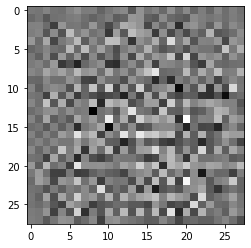

In [4]:
# Create a noise vector (dims must match the layers.Dense() input_shape)
noise = tf.random.normal([1, 100])

generator = generator_model()
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

For the <b>Discriminator</b>, we'll use a basic CNN architecture to classify either True/False (one class output).

In [5]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2),
                           padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same',))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model# To plot model architecture
#!pip3 install pydot

Test out our (untrained) Discriminator with the fake image that our (untrained) Generator just output.<br>
Note: a positive value = "real, and negative = "fake".

In [6]:
discriminator = discriminator_model()
prediction = discriminator(generated_image)
print("Prediction: ", prediction)

Prediction:  tf.Tensor([[0.00080099]], shape=(1, 1), dtype=float32)


### Define the loss functions and optimizers

In [7]:
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

For the <b>Generator</b>, the loss is telling us how well it's able to trick the Discriminator with it's fake images.  When the Generator is doing well, the Discriminator classifies the fake images as real (1).  <br>
We'll compare the Discriminator's predictions of the generated images to an array of ones.

In [8]:
def generator_loss(fake_images):
    return cross_entropy_loss(tf.ones_like(fake_images), fake_images)

For the <b>Discriminator</b>, the loss is telling us how well it's able to distinguish the real vs fake images.  We'll compare the Discriminator's predictions of real images to an array of ones, and the discriminator's predictions of fake images (generated) to an array of zeros.

In [9]:
def discriminator_loss(real_images, fake_images):
    real_loss = cross_entropy_loss(tf.ones_like(real_images), real_images)
    fake_loss = cross_entropy_loss(tf.zeros_like(fake_images), fake_images)
    total_loss = real_loss + fake_loss
    
    return total_loss

In [10]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Note: Since the Generator and Discriminator networks are trained separately (alternated), we use separate optimizers for each.

### Save model checkpoints during the training process

Since it can take a while to train a GAN (especially more complex networks), it's probably a good idea to save model checkpoints along the way in case the training process gets inturupted.

In [11]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator, discriminator=discriminator)
num_epochs_save_model = 15 

### Define the training function

Training starts with our Generator receiving a random noise vector (seed) as an input.  That random noise vector is forward propagated through the untrained Generator network and used to produce a fake image.<br>
Then, the Discriminator is used to clasify a combination of real images (MNIST dataset) and fake images (created by our Generator).<br>
Then, the loss for each model is calculated and the gradients are used to update each model's parameters (weights).<br>
We'll continue this loop for N number of epochs and watch as the Generator and Discriminator start learning how to generate and distinguish images.

In [12]:
# Define some training parameters
EPOCHS = 100
noise_dim = 100 # length of the noise vector used as input to the Generator
num_imgs_to_generate = 16

# We'll use the same seed so that we can watch the GAN progress over time via our output images
seed = tf.random.normal([num_imgs_to_generate, noise_dim])

@tf.function
def training_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # Record both the gen. and disc. gradients
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generator_images = generator(noise, training=True)
        
        real_imgs_output = discriminator(real_images, training=True)
        fake_imgs_output = discriminator(generator_images, training=True)
        
        gen_loss = generator_loss(fake_imgs_output)
        disc_loss = discriminator_loss(real_imgs_output, fake_imgs_output)
        
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [13]:
def train_gan(dataset, epochs):
    for epoch in range(epochs):
        epoch_start = time.time()
        
        for image_batch in dataset:
            training_step(image_batch)
        
        # Create images of our GANs progress to use in a GIF 
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        # Save the model checkpoint
        if (epoch +1) % num_epochs_save_model == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print("Training duration for epoch {} = {} sec".format(epoch +1, time.time() - epoch_start))

    # Display the training results (Generator's fake image) after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [14]:
def generate_and_save_images(model, epoch, test_input_seed):
    # Since we are only wanting to generate an image for visualization, we set the 
    # generator model to Inference Mode (training=False)
    predictions = model(test_input_seed, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    
    # Plot each generated image and convert pixels back to [0, 256] scale
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i, :, :, 0] * 127.5) + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('./saved_imgs/image_for_epoch_{:04d}.png'.format(epoch))
    plt.show()

### Almost there... now it's time to train the GAN!

It's important what we keep an eye on the Generator and Discriminator losses to make sure that one model isn't overpowering the other, which can lead to mode collapse and for the generator to stop learning.

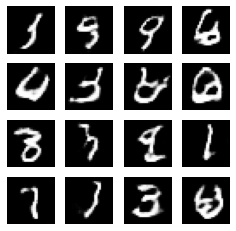

In [15]:
train_gan(train_dataset, EPOCHS)

### Create a GIF of the Generator's training progress

Now that we're done training our GAN, we'll use `imageio` to create an animated GIF using the images saved during training.

In [16]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [17]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('./saved_imgs/image_for_epoch_{:04d}.png'.format(epoch_no))

Display the training results from the last training epoch number.

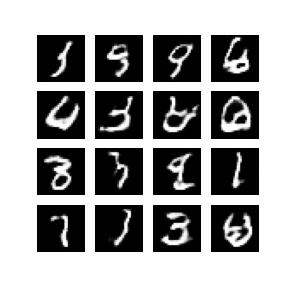

In [18]:
display_image(EPOCHS)

In [19]:
anim_file = './saved_imgs/dcgan_training.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./saved_imgs/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


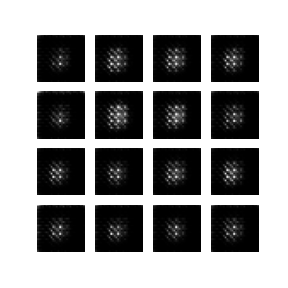

In [20]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)